# Ranking System

In this notebook we create a system to rank the merchants within each segment. 

First create a spark session and read in the engineered data.

In [54]:
from pyspark.sql import SparkSession, functions as f
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
spark = (
    SparkSession.builder.appName("ranking_system")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '3g')   
    .config('spark.executor.memory', '4g')  
    .config('spark.executor.instances', '2')  
    .config('spark.executor.cores', '2')
    .getOrCreate()
)

In [39]:
ranking_df = spark.read.parquet("../../../data/ranking_data.parquet")

In [40]:
ranking_df.show()

+------------+--------------------+-------------+-------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+--------------------+---------------------------------+--------------------+------------------+---------------------------------+
|merchant_abn|                name|revenue_level|          take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_o

Standardise the numerical data to then use for weighted ranking system

In [41]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline

In [42]:
# Columns to be standardized
numerical_columns = ['bnpl_maximum_gain', 'number_of_unique_consumers', 'number_of_repeat_consumers', 
                     'average_repeat_transactions_per_consumer', 'number_of_orders', 'average_cost_of_order', 
                     'average_spend_per_consumer', 'average_monthly_diff_consumers','consumer_diff_over_period', 
                     'average_growth_consumers', 'transcation_period_months', 'number_of_postcodes', 
                     'avg_total_weekly_personal_income', 'avg_total_weekly_fam_income', 'avg_median_age', 
                     'avg_household_size', 'avg_num_of_consumers_per_postcode', 'predicted_num_of_unique_customers']


# Create a VectorAssembler to assemble the numerical features into a vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features')

# Create a MinMaxScaler to scale the features
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Define a UDF to extract elements from the dense vector
extract_feature_udf = udf(lambda vector, i: float(vector[i]), DoubleType())

# Create a Pipeline to chain assembling and scaling stages
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data using the pipeline
model = pipeline.fit(ranking_df)
scaled_df = model.transform(ranking_df)

# Replace the original columns with MinMax scaled values
for i, col in enumerate(numerical_columns):
    scaled_df = scaled_df.withColumn(col, extract_feature_udf('scaled_features', lit(i)))

# Drop the 'scaled_features' column as it is no longer needed
scaled_df = scaled_df.drop('scaled_features', 'features')

# Show the first few rows of the DataFrame with MinMax scaled values
scaled_df.show(truncate=False)

+------------+-------------------------------------+-------------+-------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+---------------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+--------------------+--------------------------------+---------------------------+-------------------+-------------------+--------------------+---------------------------------+----------------------+---------------------+---------------------------------+
|merchant_abn|name                                 |revenue_level|take_rate          |average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactio

Remove date columns

In [43]:
# Select columns other than 'first_recorded_transaction' and 'last_recorded_transaction'
date_columns = [col for col in scaled_df.columns if col not in ['first_recorded_transaction', 'last_recorded_transaction']]

# Select only the desired columns
scaled_df = scaled_df.select(date_columns)

Weight the columns to be used in ranking system, absolute value of weights to add to 1

In [44]:
FRAUD_WEIGHTS = -0.01
VERY_IMPORTANT_FEATURES = 0.1 #6
IMPORTANT_FEATURES = 0.04 #7
OTHER_FEATURES = 0.0125 #8

# Define the weights for each attribute as a dictionary
# Replace 'attribute_name' with the actual attribute names and assign their weights
attribute_weights = {
	'bnpl_maximum_gain': VERY_IMPORTANT_FEATURES,
	'average_merchant_fraud_probability': FRAUD_WEIGHTS,
	'number_of_unique_consumers' : IMPORTANT_FEATURES,
	'average_consumer_fraud_probability': FRAUD_WEIGHTS,
	'number_of_repeat_consumers': IMPORTANT_FEATURES,
	'average_repeat_transactions_per_consumer': IMPORTANT_FEATURES,
	'number_of_orders': VERY_IMPORTANT_FEATURES,
	'average_cost_of_order': VERY_IMPORTANT_FEATURES,
	'average_spend_per_consumer': IMPORTANT_FEATURES,
	'average_monthly_diff_consumers': OTHER_FEATURES,
	'consumer_diff_over_period': IMPORTANT_FEATURES,
	'average_growth_consumers': IMPORTANT_FEATURES,
	'transcation_period_months': OTHER_FEATURES,
	'number_of_postcodes': IMPORTANT_FEATURES,
	'avg_total_weekly_personal_income': OTHER_FEATURES,
	'avg_total_weekly_fam_income': OTHER_FEATURES,
	'avg_median_age': OTHER_FEATURES,
	'avg_household_size': OTHER_FEATURES,
	'postcode_reach': OTHER_FEATURES,
	'avg_num_of_consumers_per_postcode': OTHER_FEATURES,
	'predicted_num_of_unique_customers': VERY_IMPORTANT_FEATURES,
}

# Create a SQL expression to calculate the weighted sum
weighted_sum_expr = " + ".join([f"{column_name} * {attribute_weights[column_name]}" for column_name in attribute_weights.keys()])

# Calculate the weighted sum using selectExpr
scaled_df_with_weighted_sum = scaled_df.selectExpr("*", f"({weighted_sum_expr}) as weighted_sum")

# Show the DataFrame with the new weighted sum column
scaled_df_with_weighted_sum.show()

+------------+--------------------+-------------+-------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+--------------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+-------------------------+--------------------+--------------------------------+---------------------------+-------------------+-------------------+--------------------+---------------------------------+--------------------+--------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|          take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|    number_of_orders|average_cost_of_order|average_spe

In [45]:
# Get unique values from the 'segment' column
unique_segments = scaled_df_with_weighted_sum.select('segment').distinct()

# Extract the unique values and print them
unique_segments_list = [row.segment for row in unique_segments.collect()]
print(unique_segments_list)


['garden_and_furnishings', 'antiques_and_jewellery', 'specialized_services', 'tech_and_electronics', 'retail_and_novelty']


Seperate the dataframe into the 5 different segemnts

In [46]:
retail_and_novelty_df = scaled_df_with_weighted_sum.filter(scaled_df_with_weighted_sum.segment == 'retail_and_novelty')
specialized_services_df = scaled_df_with_weighted_sum.filter(scaled_df_with_weighted_sum.segment == 'specialized_services')
tech_and_electronics_df = scaled_df_with_weighted_sum.filter(scaled_df_with_weighted_sum.segment == 'tech_and_electronics')
garden_and_furnishings_df = scaled_df_with_weighted_sum.filter(scaled_df_with_weighted_sum.segment == 'garden_and_furnishings')
antiques_and_jewellery_df = scaled_df_with_weighted_sum.filter(scaled_df_with_weighted_sum.segment == 'antiques_and_jewellery')

Rank the each segment based on weighted sum

In [47]:
# Order by 'weighted_sum' column in descending order and select top 10 for each segment
retail_and_novelty_top_10 = retail_and_novelty_df.orderBy(scaled_df_with_weighted_sum.weighted_sum.desc()).limit(10)
specialized_services_top_10 = specialized_services_df.orderBy(scaled_df_with_weighted_sum.weighted_sum.desc()).limit(10)
tech_and_electronics_top_10 = tech_and_electronics_df.orderBy(scaled_df_with_weighted_sum.weighted_sum.desc()).limit(10)
garden_and_furnishings_top_10 = garden_and_furnishings_df.orderBy(scaled_df_with_weighted_sum.weighted_sum.desc()).limit(10)
antiques_and_jewellery_top_10 = antiques_and_jewellery_df.orderBy(scaled_df_with_weighted_sum.weighted_sum.desc()).limit(10)

In [48]:
retail_and_novelty_top_10.show()

+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+-------------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+-------------------------+-------------------+--------------------------------+---------------------------+-------------------+-------------------+------------------+---------------------------------+------------------+-------------------+---------------------------------+-------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|   number_of_orders|average_cost_of_order|average_spend_per_cons

Display rankings

In [49]:
# Print the top 10 for each segment
print("Retail and Novelty Top 10:")
for idx, row in enumerate(retail_and_novelty_top_10.collect(), 1):
    print(f"{idx}. {row.name}")

print("\nSpecialized Services Top 10:")
for idx, row in enumerate(specialized_services_top_10.collect(), 1):
    print(f"{idx}. {row.name}")

print("\nTech and Electronics Top 10:")
for idx, row in enumerate(tech_and_electronics_top_10.collect(), 1):
    print(f"{idx}. {row.name}")

print("\nGarden and Furnishings Top 10:")
for idx, row in enumerate(garden_and_furnishings_top_10.collect(), 1):
    print(f"{idx}. {row.name}")

print("\nAntiques and Jewellery Top 10:")
for idx, row in enumerate(antiques_and_jewellery_top_10.collect(), 1):
    print(f"{idx}. {row.name}")

Retail and Novelty Top 10:
1. Lacus Consulting
2. Vehicula Pellentesque Corporation
3. Lobortis Ultrices Company
4. Orci In Consequat Corporation
5. Ipsum Dolor Sit Corporation
6. Dictum Phasellus In Institute
7. Phasellus At Company
8. Ultricies Dignissim LLP
9. Ornare Fusce Inc.
10. Faucibus Leo Ltd

Specialized Services Top 10:
1. Suspendisse Dui Corporation
2. Dignissim Maecenas Foundation
3. Ornare Limited
4. Euismod Et Institute
5. Ultricies Sem Limited
6. Suspendisse Non Leo PC
7. Magna Praesent PC
8. Sit Amet PC
9. Montes Nascetur Ridiculus Limited
10. Sed Dictum PC

Tech and Electronics Top 10:
1. Mauris Non Institute
2. Placerat Eget Venenatis Limited
3. Nullam Consulting
4. Suspendisse Ac Associates
5. Arcu Sed Eu Incorporated
6. Eleifend PC
7. Eros Limited
8. Vel Est Tempor LLP
9. Eu Placerat LLC
10. Diam At Foundation

Garden and Furnishings Top 10:
1. Est Nunc Consulting
2. Non Vestibulum Industries
3. Erat Vitae LLP
4. Pede Nonummy Corp.
5. Lorem Ipsum Sodales Industries

Analyse the top 100

In [51]:
# Order by 'weighted_sum' column in descending order and select top 100
scaled_df_top_100 = scaled_df_with_weighted_sum.orderBy(scaled_df_with_weighted_sum.weighted_sum.desc()).limit(100)
scaled_df_top_100.show()

+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+-------------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+-------------------------+-------------------+--------------------------------+---------------------------+-------------------+-------------------+------------------+---------------------------------+--------------------+-------------------+---------------------------------+-------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|   number_of_orders|average_cost_of_order|average_spend_per_co

Pie chart of breakdown of the make up of the top 100 merchants by segment

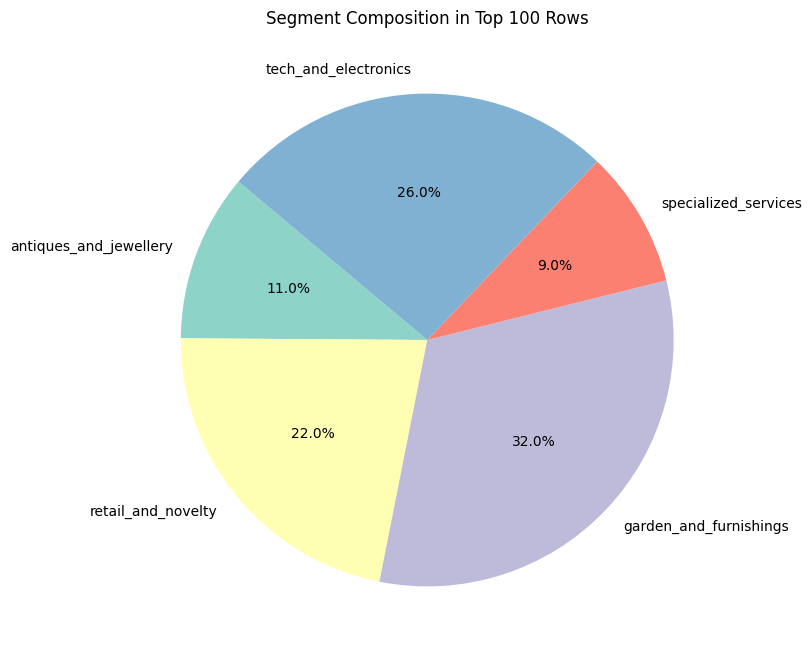

In [55]:
# Group by segment and count the occurrences of each segment in the top 100 scaled_df
agg_segments = scaled_df_top_100.groupBy("segment").agg(
    f.count("*").alias("segment_count")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
segments_pandas = agg_segments.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(segments_pandas["segment_count"], labels=segments_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(segments_pandas)))
plt.title('Segment Composition in Top 100 Rows')
plt.show()
